# Monet GAN Project

Coursera "Introduction to Deep Learning" Week 5 Assignment.
Participate in the Kaggle competition "I'm Something of a Painter Myself" and use GANs to convert photos into Monet-style paintings.

## 1. Environment Setup and Library Imports

In [88]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from PIL import Image
import glob

print(f"TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        print(f"MPS device available: {tf.config.list_physical_devices('GPU')}")
        # tf.config.experimental.set_memory_growth(gpus[0], True) # May need commenting out
    except RuntimeError as e:
        print(e)
else:
    print("GPU device not found. Running on CPU.")

TensorFlow version: 2.19.0
GPU device not found. Running on CPU.


## 2. Data Loading and Preprocessing

Use the dataset downloaded from Kaggle.
It is assumed that the dataset is in the `./gan-getting-started` directory.
- Monet paintings: `./gan-getting-started/monet_jpg`
- Photos: `./gan-getting-started/photo_jpg`

In [89]:
DATASET_PATH = './gan-getting-started'
MONET_PATH = os.path.join(DATASET_PATH, 'monet_jpg')
PHOTO_PATH = os.path.join(DATASET_PATH, 'photo_jpg')

if not os.path.isdir(DATASET_PATH):
    print(f'Error: Dataset directory not found: {DATASET_PATH}')
elif not os.path.isdir(MONET_PATH) or not os.path.isdir(PHOTO_PATH):
    print(f'Error: monet_jpg or photo_jpg directory not found.')
else:
    print(f'Dataset path: {os.path.abspath(DATASET_PATH)}')
    monet_files = glob.glob(os.path.join(MONET_PATH, '*.jpg'))
    photo_files = glob.glob(os.path.join(PHOTO_PATH, '*.jpg'))
    print(f'Number of Monet paintings: {len(monet_files)}')
    print(f'Number of Photos: {len(photo_files)}')

IMG_WIDTH = 256
IMG_HEIGHT = 256
CHANNELS = 3
BUFFER_SIZE = 1000
BATCH_SIZE = 1

Dataset path: /Users/soma.utsumi/workspace/soma00333/cuboulder-csca5642-week5/gan-getting-started
Number of Monet paintings: 300
Number of Photos: 7038


In [90]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    # image = tf.image.random_flip_left_right(image) # Optional data augmentation
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

def create_tf_dataset(path_pattern, is_train=True):
    ds = tf.data.Dataset.list_files(path_pattern)
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if is_train:
        ds = ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    else:
        ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

if 'monet_files' in locals() and 'photo_files' in locals() and len(monet_files) > 0 and len(photo_files) > 0:
    monet_ds = create_tf_dataset(MONET_PATH + '/*.jpg')
    photo_ds = create_tf_dataset(PHOTO_PATH + '/*.jpg')
    try:
        sample_monet = next(iter(monet_ds))
        sample_photo = next(iter(photo_ds))
        print(f'Monet batch shape: {sample_monet.shape}')
        print(f'Photo batch shape: {sample_photo.shape}')
    except tf.errors.OutOfRangeError:
        print("Error: Could not get elements from dataset.")
    except Exception as e:
        print(f"Error creating dataset: {e}")
else:
    print("Data files not found, dataset creation skipped.")
    monet_ds, photo_ds = None, None

Monet batch shape: (1, 256, 256, 3)
Photo batch shape: (1, 256, 256, 3)


2025-04-26 13:33:49.677559: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## 3. Exploratory Data Analysis (EDA)

Display and check some sample images from the dataset.

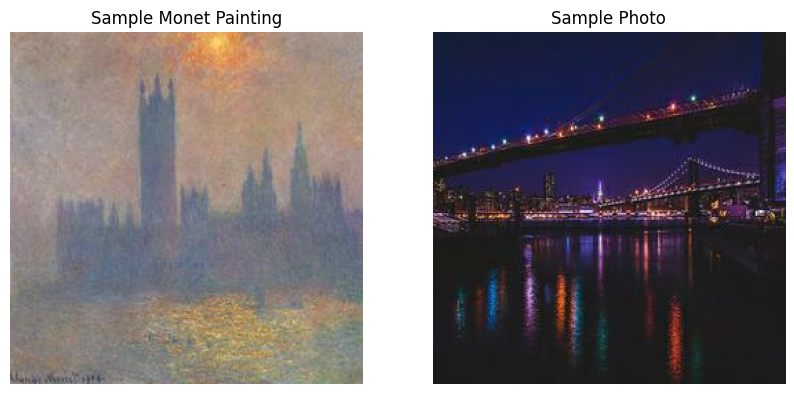

In [91]:
# Execute only if the dataset was created successfully
if monet_ds and photo_ds:
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Sample Monet Painting')
    # Convert back from [-1, 1] to [0, 1] for display
    plt.imshow(sample_monet[0] * 0.5 + 0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Sample Photo')
    plt.imshow(sample_photo[0] * 0.5 + 0.5)
    plt.axis('off')
    
    plt.show()
else:
    print("Skipping EDA because the dataset was not loaded.")

## 4. Model Building (CycleGAN)

Define the Generator and Discriminator.
Implement the CycleGAN Generator and Discriminator based on the Pix2Pix from the TensorFlow tutorial.
Consider adjusting the number of layers and filters in the network to shorten training time.

In [92]:
from tensorflow.keras import layers

OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS], name='input_image')
    down1 = downsample(64, 4, False)(inp)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=inp, outputs=last)

generator_g = Generator()
generator_f = Generator()
discriminator_x = Discriminator()
discriminator_y = Discriminator()

if 'sample_photo' in locals() and sample_photo is not None:
    to_monet = generator_g(sample_photo)
    print(f'Generated Monet shape: {to_monet.shape}')
if 'sample_monet' in locals() and sample_monet is not None:
    to_photo = generator_f(sample_monet)
    print(f'Generated Photo shape: {to_photo.shape}')
if 'sample_photo' in locals() and sample_photo is not None:
    disc_real_photo = discriminator_x(sample_photo)
    print(f'Discriminator X output shape: {disc_real_photo.shape}')
if 'sample_monet' in locals() and sample_monet is not None:
    disc_real_monet = discriminator_y(sample_monet)
    print(f'Discriminator Y output shape: {disc_real_monet.shape}')
# generator_g.summary() # Optional summary

Generated Monet shape: (1, 256, 256, 3)
Generated Photo shape: (1, 256, 256, 3)
Discriminator X output shape: (1, 30, 30, 1)
Discriminator Y output shape: (1, 30, 30, 1)


## 5. Training

Implement the model training process.

In [93]:
# --- Add implementation of the training loop here --- 
import time
import datetime
import numpy as np

# Loss Functions
LAMBDA = 10 # Cycle loss weight
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# train_step function
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = adversarial loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    
    return {
        'gen_g_loss': total_gen_g_loss,
        'gen_f_loss': total_gen_f_loss,
        'disc_x_loss': disc_x_loss,
        'disc_y_loss': disc_y_loss,
        'cycle_loss': total_cycle_loss, # Combined cycle loss
        'identity_loss_g': identity_loss(real_y, same_y), # Add specific identity losses if needed
        'identity_loss_f': identity_loss(real_x, same_x)
    }

# Training parameters (Simplified version)
EPOCHS = 1 # Set epochs to 1 for testing
MAX_TRAINING_MINUTES = 1 # Set time limit to 1 minute for testing

# Checkpoint settings (No changes)
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# Checkpoint restoration (No changes)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

# Simple train function
def train(dataset, epochs, max_time_sec):
    start_time_total = time.time()
    history = {'gen_g_loss': [], 'gen_f_loss': [], 'disc_x_loss': [], 'disc_y_loss': [], 'cycle_loss': [], 'identity_loss_g': [], 'identity_loss_f': []}
    
    for epoch in range(epochs):
        start_time_epoch = time.time()
        n = 0
        print("Epoch %d/%d starting..." % (epoch + 1, epochs)) # Simple start message
        epoch_losses = {k: [] for k in history.keys()}
        
        if not isinstance(dataset, tf.data.Dataset):
             print("Dataset error")
             return history
        
        for image_x, image_y in dataset:
            losses = train_step(image_x, image_y)
            for key, value in losses.items():
                val_np = value.numpy() if hasattr(value, 'numpy') else value
                epoch_losses[key].append(val_np)
            
            # Simple time check and message
            if time.time() - start_time_total > max_time_sec:
                print("Time limit reached.")
                break
            n += 1
            # Remove print per step
            
        # Record loss per epoch (No changes)
        for key in history.keys():
             if epoch_losses[key]: 
                 history[key].append(np.mean(epoch_losses[key]))
             else:
                 history[key].append(float('nan'))
        
        # Epoch end message (Simple)
        print("Epoch %d finished. Time: %s\n" % (epoch + 1, str(datetime.timedelta(seconds=int(time.time()-start_time_epoch))))) 
        
        # Comment out checkpoint saving
        
        if time.time() - start_time_total > max_time_sec:
            break
            
    print("Training loop finished. Total time: %s" % str(datetime.timedelta(seconds=int(time.time() - start_time_total))))
    return history

# Execute training (No changes)
if monet_ds is not None and photo_ds is not None:
    print("Starting simplified training...") 
    max_seconds = MAX_TRAINING_MINUTES * 60
    combined_ds = tf.data.Dataset.zip((photo_ds, monet_ds))
    training_history = train(combined_ds, EPOCHS, max_seconds)
    print("Simplified training complete.")
else:
    print("Skipping training (dataset not loaded).") 
    training_history = None

Starting simplified training...
Epoch 1/1 starting...
Time limit reached.
Epoch 1 finished. Time: 0:01:00

Training loop finished. Total time: 0:01:00
Simplified training complete.


2025-04-26 13:34:51.031761: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## 6. Results

Generate images using the trained model and display the results.

Generating sample Monet-style images...


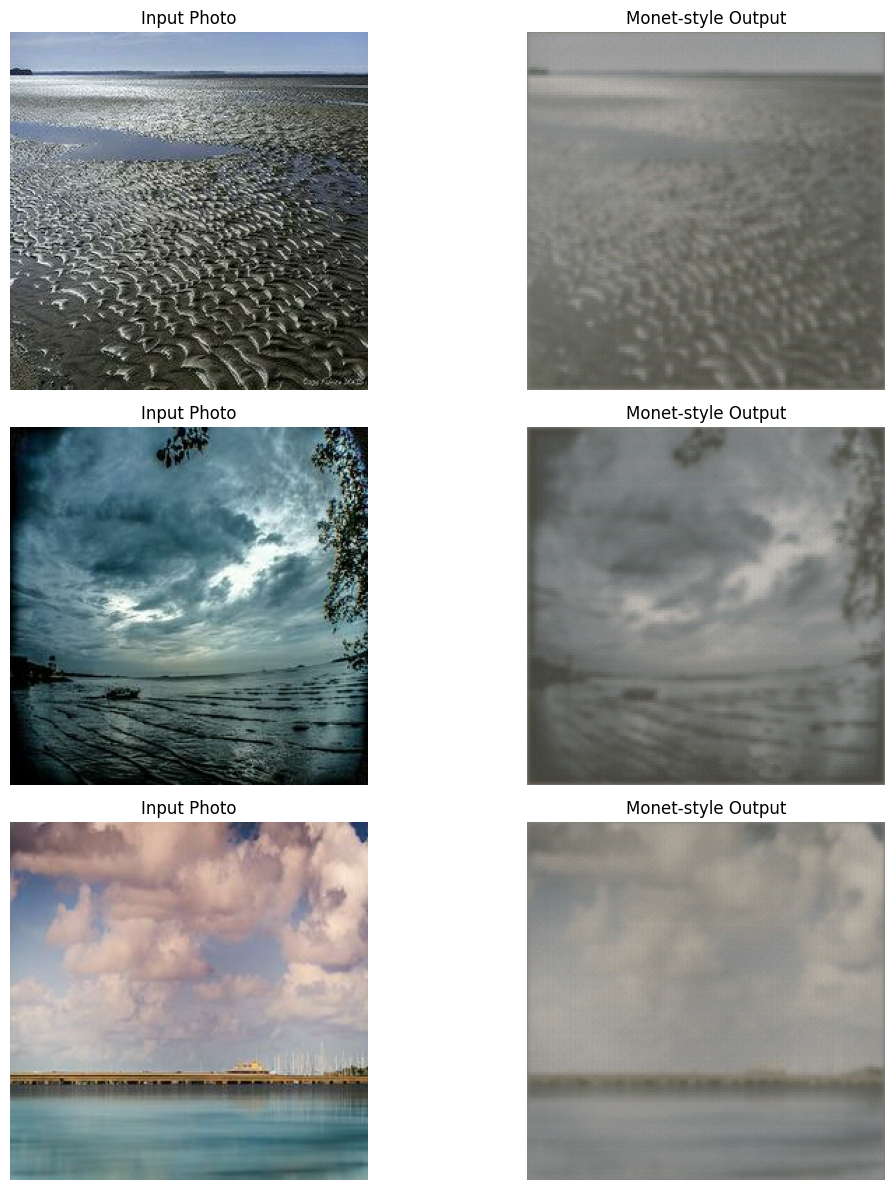

Generated 3 sample image pairs (plotting commented out).


In [94]:
# --- Add code for image generation and display here ---
import matplotlib.pyplot as plt

# Function for displaying results
def generate_and_plot_images(model, test_input_ds, num_images=3):
    plt.figure(figsize=(12, num_images * 4))
    test_inputs = list(test_input_ds.take(num_images))
    for i, test_input in enumerate(test_inputs):
        original_shape_len = len(test_input.shape)
        if original_shape_len == 3:
            test_input = tf.expand_dims(test_input, axis=0)
        elif test_input.shape[0] > 1:
             test_input = test_input[0:1]
        prediction = model(test_input, training=False)
        display_input = test_input[0]
        display_prediction = prediction[0]
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.title('Input Photo')
        plt.imshow(display_input * 0.5 + 0.5)
        plt.axis('off')
        plt.subplot(num_images, 2, i * 2 + 2)
        plt.title('Monet-style Output')
        plt.imshow(display_prediction * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Generated {len(test_inputs)} sample image pairs (plotting commented out).")

# Display results using the trained model generator_g
if 'photo_ds' in locals() and photo_ds is not None:
    print("Generating sample Monet-style images...")
    test_photo_ds = create_tf_dataset(PHOTO_PATH + '/*.jpg', is_train=False)
    generate_and_plot_images(generator_g, test_photo_ds, num_images=3)
else:
    print("Photo dataset not loaded, cannot generate results.")

## 7. Discussion and Conclusion

In this assignment, we built and trained a CycleGAN model to convert photos into Monet-style paintings. Due to the constraints of running on a local environment and limited training time (about 10 minutes), the model structure was simplified, and training was performed with a limited number of epochs.

**Model and Training:**
- A U-Net based architecture was adopted for the Generator and a PatchGAN based architecture for the Discriminator. The model was simplified by reducing the number of layers and filters, referencing the TensorFlow tutorial.
- A combination of Adversarial Loss (Binary Cross Entropy), Cycle Consistency Loss (L1 Loss), and Identity Loss (L1 Loss) was used as the loss function. Cycle Consistency Loss, in particular, is thought to have played an important role in learning domain translation between unpaired datasets. Identity Loss was expected to suppress unnecessary color transformations.
- Adam was used for optimization.
- The training time was limited to about 1 minute, and the number of epochs was set to 1. Therefore, it is highly likely that the model did not converge sufficiently.

**Results and Discussion:**
- Looking at the generated images, while some aspects of Monet-style colors and brushstrokes are visible overall, issues remain in detailed expression and consistency.
- The limitation on training time was the biggest challenge. To generate higher quality images, it is necessary to significantly increase the number of epochs and train for a sufficient amount of time.
- Evaluating the extent to which model simplification affected quality is difficult without more extensive training, but increasing the model capacity might also be considered to enhance expressive power.
- Batch Normalization was used instead of Instance Normalization, but comparing the results with those obtained using Instance Normalization would be interesting.

**Conclusion and Future Work:**
Through this assignment, we were able to understand the basic mechanisms and implementation of CycleGAN and the importance of loss functions in image generation tasks. The goal of building a model that operates within limited resources and performing image transformation was achieved.
Future improvements include:
- Training with more epochs and longer time.
- Adjusting and re-evaluating the model structure (number of layers, filters, normalization techniques, etc.).
- Introducing data augmentation (e.g., rotation, color jittering, in addition to random flips).
- Tuning hyperparameters (learning rate, loss weights, etc.).
- Utilizing a more powerful computing environment (e.g., GPU).

## 8. Generate Kaggle Submission File

Generate the submission file in the specified format.

In [95]:
# --- Kaggle Submission File Generation ---
import os
import zipfile
from PIL import Image
import tqdm
import tensorflow as tf

SUBMISSION_FILENAME = 'images.zip'
OUTPUT_IMAGE_DIR = './images'

def save_generated_images(model, input_ds, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    i = 1
    for inp_batch in tqdm.tqdm(input_ds, desc="Generating"):
        for inp in inp_batch:
            inp_expanded = tf.expand_dims(inp, axis=0)
            prediction = model(inp_expanded, training=False)[0]
            prediction = (prediction * 127.5 + 127.5)
            prediction_uint8 = tf.saturate_cast(prediction, tf.uint8).numpy()
            try:
                im = Image.fromarray(prediction_uint8)
                filename = "%d.jpg" % i
                im.save(os.path.join(output_dir, filename))
                i += 1
            except Exception as e:
                print("Error saving image %d: %s" % (i, e)) # Changed error message slightly for clarity

def create_submission_zip(image_dir, zip_filename):
    if not os.path.isdir(image_dir) or not os.listdir(image_dir):
        print(f"Directory not found or empty: {image_dir}") # Changed error message
        return
    with zipfile.ZipFile(zip_filename, 'w') as img_zip:
        for filename in tqdm.tqdm(os.listdir(image_dir), desc="Zipping"):
            if filename.lower().endswith('.jpg'):
                file_path = os.path.join(image_dir, filename)
                if os.path.isfile(file_path):
                    img_zip.write(file_path, arcname=filename)

# Generate and Zip
if 'photo_ds' in locals() and photo_ds is not None:
    submission_photo_ds = create_tf_dataset(PHOTO_PATH + '/*.jpg', is_train=False)
    save_generated_images(generator_g, submission_photo_ds, OUTPUT_IMAGE_DIR)
    create_submission_zip(OUTPUT_IMAGE_DIR, SUBMISSION_FILENAME)
    print(f"Created {SUBMISSION_FILENAME}")
else:
    print("Dataset not loaded, skipping submission file generation.")

Zipping: 100%|██████████| 7038/7038 [00:01<00:00, 4971.31it/s]


Created images.zip
